In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/finetuning.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_path = 'Data/train'
valid_path = 'Data/valid'
test_path = 'Data/test'

train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size = (224,224),
                                                         batch_size = 10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size = (224,224),
                                                         batch_size = 30)

test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                         target_size = (224,224),
                                                         batch_size = 50,
                                                        shuffle = False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [4]:
base_model = vgg16.VGG16(weights = 'imagenet', include_top=False, input_shape=(224,224,3), pooling = 'avg')

58889256/58889256 [==============================] - 4s 0us/step


In [5]:
for layer in base_model.layers[:-5]:
  layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
last_output = base_model.output
x = Dense(10, activation = 'softmax', name = 'softmax')(last_output)
new_model = Model(inputs = base_model.input, outputs = x)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
new_model.compile(Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath = 'signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18, validation_data=valid_batches,
                                  validation_steps = 3, epochs =20, verbose = 1, callbacks = [checkpointer])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-8-a3542a470c97>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18, validation_data=valid_batches,


Epoch 1/20
18/18 [==============================] - 17s 374ms/step - loss: 3.8705 - accuracy: 0.2111 - val_loss: 2.0368 - val_accuracy: 0.3444
Epoch 2/20
18/18 [==============================] - 2s 122ms/step - loss: 1.7949 - accuracy: 0.3722 - val_loss: 1.5514 - val_accuracy: 0.4667
Epoch 3/20
18/18 [==============================] - 2s 139ms/step - loss: 1.1363 - accuracy: 0.6111 - val_loss: 1.0327 - val_accuracy: 0.6111
Epoch 4/20
18/18 [==============================] - 2s 110ms/step - loss: 0.6928 - accuracy: 0.7667 - val_loss: 0.6545 - val_accuracy: 0.8333
Epoch 5/20
18/18 [==============================] - 2s 125ms/step - loss: 0.5571 - accuracy: 0.8222 - val_loss: 0.3487 - val_accuracy: 0.9111
Epoch 6/20
18/18 [==============================] - 2s 114ms/step - loss: 0.4169 - accuracy: 0.8556 - val_loss: 0.4079 - val_accuracy: 0.8556
Epoch 7/20
18/18 [==============================] - 2s 97ms/step - loss: 0.2500 - accuracy: 0.9278 - val_loss: 0.4436 - val_accuracy: 0.8889
Epoch 

In [9]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

def load_dataset(path):
  data = load_files(path)
  paths = np.array(data['filenames'])
  targets = np_utils.to_categorical(np.array(data['target']))
  return paths, targets

test_files, test_targets = load_dataset('Data/test')

In [19]:
import keras.utils as image
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

In [20]:
def path_to_tensor(img_path):
  img = image.load_img(img_path, target_size = (224,224))
  x = image.img_to_array(img)
  return np.expand_dims(x, axis = 0)

def paths_to_tensors(img_paths):
  list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
  return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensors(test_files))

100%|██████████| 50/50 [00:00<00:00, 1128.07it/s]


In [21]:
print('\n test loss ; {:.4f}\nTest accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

2/2 [==============================] - 8s 3s/step - loss: 0.2026 - accuracy: 0.9200

 test loss ; 0.2026
Test accuracy: 0.9200


2/2 [==============================] - 0s 151ms/step


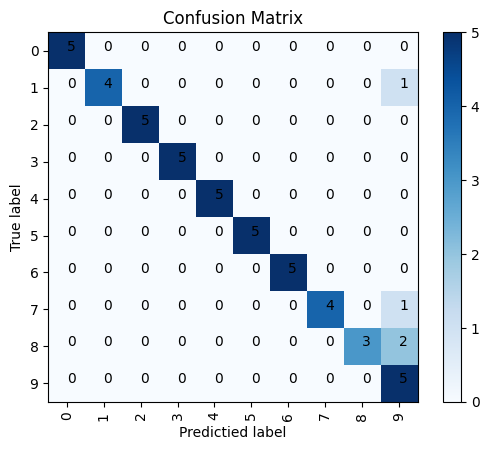

In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(np.argmax(test_targets, axis = 1), np.argmax(new_model.predict(test_tensors), axis =1))
plt.imshow(cm, cmap= plt.cm.Blues)
plt.colorbar()
cm_label = ['0','1','2','3','4','5','6','7','8','9']
indexes = np.arange(len(cm_label))
for i in indexes:
  for j in indexes:
    plt.text(j,i,cm[i,j])
plt.xticks(indexes, cm_label, rotation = 90),
plt.xlabel('Predictied label')
plt.yticks(indexes, cm_label)
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()